# Поиск ассоциативных правил и выявление скрытых структур в данных

#### Содержание:
- [Импорт библиотек](#import-libraries)
- [Загрузка данных](#data-load)
1) [Поиск ассоциативных правил](#assoc_rules)
    - [Зачем это нужно](#why_is_this_necessary)
    - [Цель 1 части работы](#goal_part1)
    - [1. кол-во различных значений переменных Product и Customer](#unique_num_count)
    - [2. Поиск частых эпизодов, используя FPTree](#fptree_freq_itemsets)
    - [3. частый эпизод с наибольшим кол-вом элементов, содержащий coke](#largest_itemsets)
    - [4. Построение ассоциативных правил](#assoc_rules_generate)
    - [5. Построение ориентированного графа](#make_graph)
    - [6. Рассчет меры центральности authority_score для построенного графа](#max_authority_find)
    - [7. Построение числовой матрицы со счетчиком числа покупок, клиентами и продуктами](#make_purchase_matrix)
2) [Выявление скрытых структур данных](#find_hidden_struct)
    - [Зачем это нужно](#why_is_this_necessary2)
    - [Цель 2 части работы](#goal_part2)
    - [8. Построение линейной проекции набора данных на плоскость с помощью NMF](#use1)
    - [9. Построение нелинейной проекции набора данных на плоскость с помощью TSNE](#use2)
    - [10. Отбор 4 независимых переменных из исходной матрицы с использованием VarClus](#varclus_use)


#### Импорт библиотек
<a id='import-libraries'></a>

In [1]:
# Для работы с данными
import pandas as pd
# Алгоритм поиска частых наборов товаров
from mlxtend.frequent_patterns import fpgrowth
# Для преобразования списка покупок в формат для анализа
from mlxtend.preprocessing import TransactionEncoder
# Для генерации ассоциативных правил (если а, то б)
from mlxtend.frequent_patterns import association_rules
# Для построения и визуализации графов связей между товарами
import networkx as nx
import matplotlib.pyplot as plt
# Линейная проекция набора данных на плоскость
from sklearn.decomposition import NMF
# Нелинейная проекция набора данных на плоскость
from sklearn.manifold import TSNE
# Кластеризация признаков по схожести и отбор переменных
from varclushi import VarClusHi


#### Загрузка данных
<a id='data-load'></a>

In [2]:
df = pd.read_csv("data/TRANSACTION.csv")
df.head(10)

,CUSTOMER,TIME,PRODUCT
0,0,0,hering
1,0,1,corned_b
2,0,2,olives
3,0,3,ham
4,0,4,turkey
5,0,5,bourbon
6,0,6,ice_crea
7,1,0,baguette
8,1,1,soda
9,1,2,hering


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7007 entries, 0 to 7006
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   CUSTOMER  7007 non-null   int64 
 1   TIME      7007 non-null   int64 
 2   PRODUCT   7007 non-null   object
dtypes: int64(2), object(1)
memory usage: 164.4+ KB


## 1) Поиск ассоциативных правил
<a id='assoc_rules'></a>

#### Зачем это нужно?
<a id='why_is_this_necessary'></a>
Анализ покупательской корзины является довольно важной задачей, ведь она позволяет бизнесу увеличивать продажи и удерживать клиентов, путем выявления интересных правил в предпочтениях клиентов при выборе товаров/услуг. Машинное обучение позволяет автоматизировать и масштабировать этот процесс

#### Цель 1 части работы
<a id='goal_part1'></a>
Научиться проводить анализ покупательской корзины, путем проведения ассоциативного анализа и выявления скрытых структур данных. Поработать с библиотеками Mlxtend, networkx, а именно с Transaction Encoder, алгоритмом FP-growth, association_rules. Построить и визуализировать граф транзакций, рассчитать меры центральности и построить матрицу продуктов.

В файле 3 колонки:
* Customer – ID клиента,
*  Product – покупка,
*  Time – временная метка (для задания не нужна)

#### 1. Для начала определим сколько различных значений принимают переменные Product и Customer
<a id='unique_num_count'></a>

In [4]:
df[["CUSTOMER", "PRODUCT"]].nunique()

CUSTOMER    1001
PRODUCT       20
dtype: int64

#### 2. Найдем частые эпизоды с ограничением на размер правила = 4, с использованием алгоритма FPTree и порога на поддержку 3%
<a id='fptree_freq_itemsets'></a>

In [5]:
transactions = df.groupby('CUSTOMER').aggregate({"PRODUCT": list}).values[:, 0]
te = TransactionEncoder() #делаем бинарную матрицу 
te_ary = te.fit_transform(transactions)
df1 = pd.DataFrame(te_ary, columns = te.columns_)
frequent_itemsets = fpgrowth(df1, min_support=0.03, use_colnames=True, max_len = 4)
print(frequent_itemsets)

      support                           itemsets
0    0.485514                           (hering)
1    0.472527                           (olives)
2    0.402597                          (bourbon)
3    0.390609                         (corned_b)
4    0.312687                         (ice_crea)
..        ...                                ...
656  0.032967  (bourbon, chicken, cracker, soda)
657  0.031968                 (bordeaux, hering)
658  0.031968                (bordeaux, cracker)
659  0.043956               (bordeaux, heineken)
660  0.035964                 (bordeaux, olives)

[661 rows x 2 columns]


#### 3. Найдем частый эпизод с наибольшим кол-вом элементов, содержащий продукт `coke`. Также посчитаем его поддержку
<a id='largest_itemsets'></a>

In [6]:
coke_itemsets = frequent_itemsets[
    frequent_itemsets["itemsets"].apply(lambda x: 'coke' in x)
    ]
max_len_idx = [coke_itemsets["itemsets"].apply(len).idxmax()] # Индекс набора с наибольшим кол-вом элементов
largest_coke_itemsets = coke_itemsets.loc[max_len_idx]
largest_coke_itemsets_support = round(largest_coke_itemsets["support"].iloc[0], 4)

print(f"Самый большой набор с coke:\n{largest_coke_itemsets}")
print(f"Поддержка самого большого набора с coke: {largest_coke_itemsets_support}")

Самый большой набор с coke:
      support                          itemsets
194  0.094905  (ice_crea, olives, coke, turkey)
Поддержка самого большого набора с coke: 0.0949


#### 4. На основе найденных частых эпизодов построим ассоциативные правила с 20% порогом на достоверность. Найдем правило с максимальным лифтом,содержащем coke в левой части правила
<a id='assoc_rules_generate'></a>

In [7]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold = 0.2)
filtered_rules = rules[rules["antecedents"].apply(lambda x: "coke" in x)]
filtered_rules.loc[filtered_rules["lift"].idxmax()]

antecedents              (sardines, coke)
consequents           (chicken, ice_crea)
antecedent support               0.146853
consequent support                0.13986
support                          0.115884
confidence                       0.789116
lift                             5.642177
representativity                      1.0
leverage                         0.095345
conviction                       4.078728
zhangs_metric                    0.964387
jaccard                          0.678363
certainty                        0.754826
kulczynski                       0.808844
Name: 1512, dtype: object

* Поддержка (support):
    - Набор товаров встречается вместе в 11.6% случаев
* Достоверность (confidence):
    - Если покупают (coke, sardines), то с вероятностью 78.9% покупают и (ice_crea, chicken)
* Подъем (lift):
    - Набор товаров встречается вместе в 5.64 раз чаще, чем если бы они были независимыми

#### 5. Используя только двухместные правила построим ориентированный граф, где вершины элементы правила, их размер – item support, дуги – импликации (от условия к следствию), веса дуги – достоверности.
<a id='make_graph'></a>

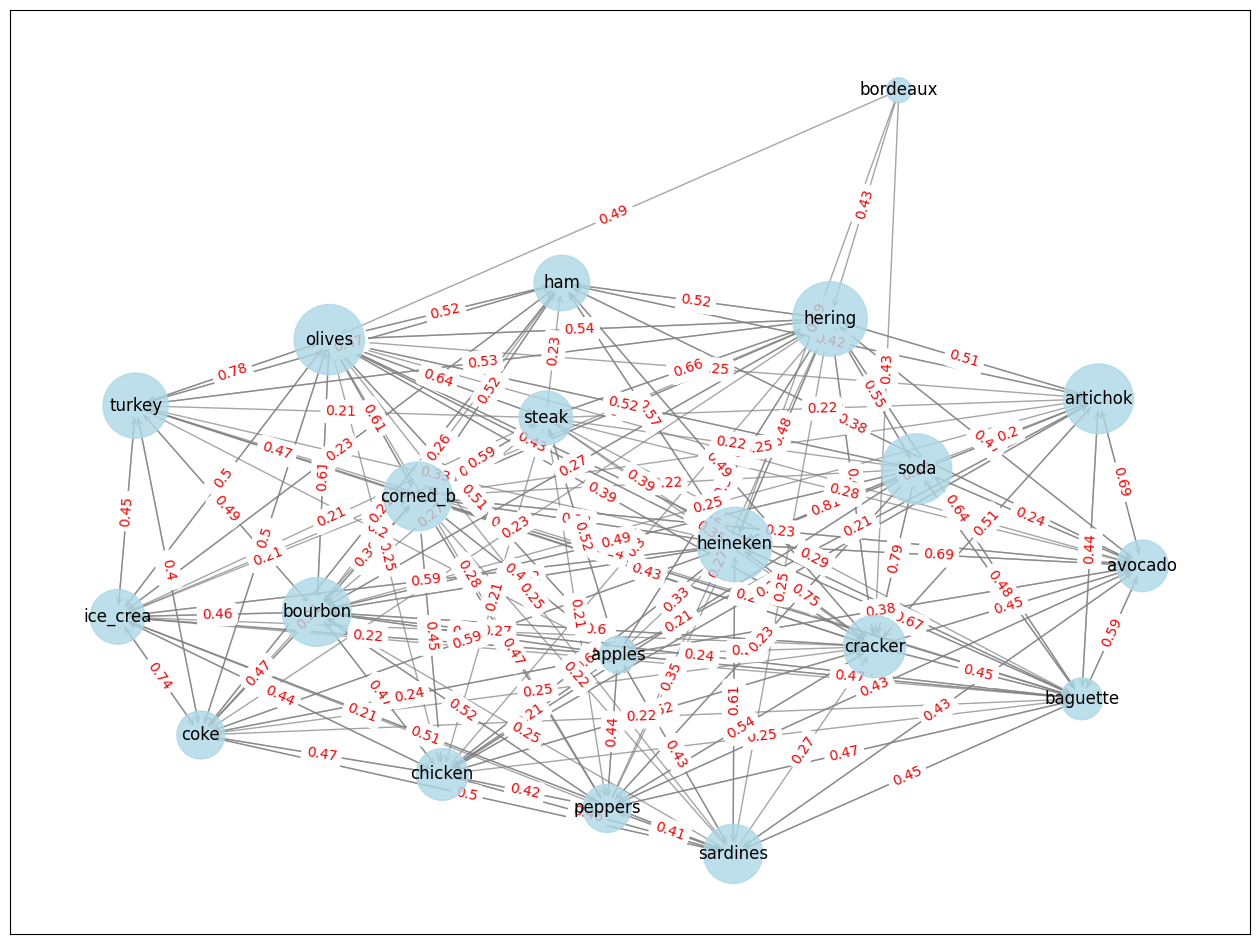

In [8]:
G = nx.DiGraph()

for index, rule in rules.iterrows():
    antecedent = list(rule['antecedents'])
    consequent = list(rule['consequents'])

    if len(antecedent) == 1 and len(consequent) == 1:
        antecedent = antecedent[0] 
        consequent = consequent[0] 
        confidence = round(rule['confidence'], 2)
        support = rule['support']

        if antecedent not in G:
            G.add_node(antecedent, support=support)
        if consequent not in G:
            G.add_node(consequent, support=support)

        G.add_edge(antecedent, consequent, weight=confidence)
        
plt.figure(figsize=(16, 12))

pos = nx.spring_layout(G)

node_sizes = [G.nodes[node]['support'] * 10000 for node in G.nodes]

nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="lightblue", alpha=0.8)
nx.draw_networkx_edges(G, pos, edge_color='grey', width=1, alpha=0.7, arrowstyle="->", arrowsize=10)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.show()

Размер узлов - мера support, веса - мера confidence

#### 6. Для данного графа рассчитаем меру центральности authority_score и найдем элемент с самой высокой мерой, а также какую меру имеет coke
<a id='max_authority_find'></a>

In [9]:
h, a = nx.hits(G)
a #словарь. Ключи - узлы графа, значения - оценки авторитетности

{'hering': 0.08658601754822291,
 'heineken': 0.10886877895966435,
 'cracker': 0.08537625277727967,
 'olives': 0.08652064514446181,
 'bourbon': 0.06690360406216625,
 'corned_b': 0.06808334321954636,
 'baguette': 0.0639878001584468,
 'ice_crea': 0.0413772809502965,
 'chicken': 0.04226960878748507,
 'apples': 0.046940941312697416,
 'ham': 0.03728891158416132,
 'avocado': 0.050826461918969494,
 'turkey': 0.02982345671903943,
 'coke': 0.03514607857059617,
 'soda': 0.036191696854866694,
 'artichok': 0.03151661199206815,
 'sardines': 0.03301366522345619,
 'peppers': 0.03571165949861277,
 'steak': 0.01356718471796254,
 'bordeaux': -0.0}

- h - hub score
    - Оценка хаба, т.е узла, который ссылается на множество авторитетных узлов. Чем выше h, тем больше узел считается хабом.

- a - authority score 
    - Оценка авторитетности узла. Авторитетный узел - тот, на который ссылается много хабов. Чем выше a, тем авторитетнее узел.

Hub ссылается на авторитеты.
Авторитеты получают ссылки от hub'ов.

In [10]:
max_authority = max(a.values())
max_authority_item = [key for key, value in a.items() if value == max_authority]
max_authority_item

['heineken']

In [11]:
a["coke"]

0.03514607857059617

#### 7. Построим числовую матрицу со счетчиком числа покупок в ячейках, клиентами по строкам и продуктами по столбцам
<a id='make_purchase_matrix'></a>

In [12]:
purchase_matrix = pd.crosstab(df["CUSTOMER"], df["PRODUCT"])
purchase_matrix

PRODUCT,apples,artichok,avocado,baguette,bordeaux,bourbon,chicken,coke,corned_b,cracker,ham,heineken,hering,ice_crea,olives,peppers,sardines,soda,steak,turkey
CUSTOMER,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,1,0,0,1,0,1,0,1,1,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0,1,1,0,1,1,0,1,0,0,1,0,0
2,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1
3,0,0,0,0,0,1,0,1,0,0,1,0,0,1,1,1,0,0,0,1
4,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0,1,1,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0
997,1,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1
998,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,2,1,0,0


## 2) Выявление скрытых структур в данных
<a id='find_hidden_struct'></a>

#### Зачем это нужно?
<a id='why_is_this_necessary2'></a>
Выявление скрытых структур в данных позволяет уменьшать их размерность, сохраняя суть, создавать интерпретируемые проекции многомерных данных на простые структуры. Это позволяет решать практические задачи выявления невидимых связей между товарами и покупателями, предсказания спроса, выявления рисков и мошенничества, а также создания персональных рекомендаций

#### Цель 2 части работы
<a id='goal_part2'></a>
Научиться выявлять скрытые связи между товарами и покупателями в задаче анализа покупательской корзины, путем построения интерпретируемых проекций многомерных данных на плоскость с помощью методов NMF и TSNE, а также выявления независимых товаров

<a id='use1'></a>
#### 8. С помощью метода NMF построим линейную проекцию набора данных на плоскость

In [13]:
assoc = df.groupby("CUSTOMER")["PRODUCT"].value_counts().unstack(fill_value=0)

model = NMF(n_components=2, init = "random")
W = model.fit_transform(purchase_matrix)
H = model.components_

In [14]:
reconstructed = pd.DataFrame(data=model.inverse_transform(W), columns = purchase_matrix.columns, index = purchase_matrix.index) #Создаем DataFrame с обратным преобразованием для анализа

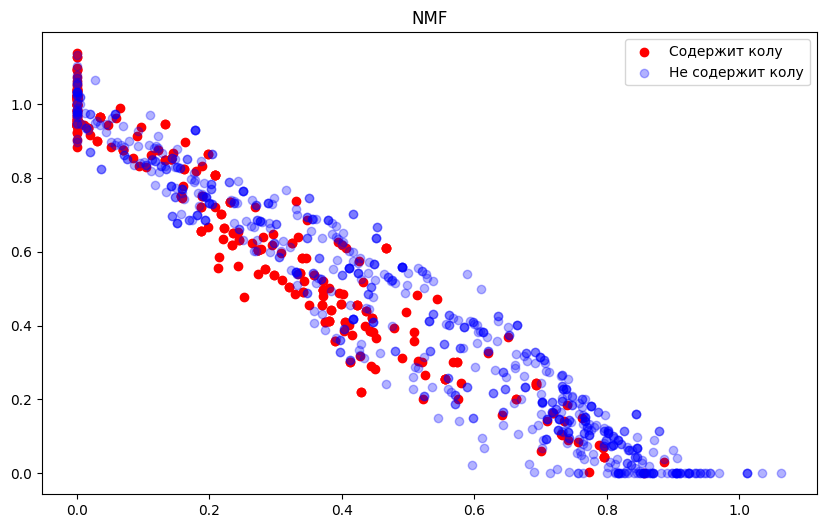

In [15]:
plt.figure(figsize=(10, 6))

contains_coke = purchase_matrix["coke"] > 0

plt.scatter(W[contains_coke, 0], W[contains_coke, 1], c='red', label='Содержит колу')
plt.scatter(W[~contains_coke, 0], W[~contains_coke, 1], c='blue', label='Не содержит колу', alpha=0.3)

plt.title('NMF')
plt.legend()
plt.show()

Классы "содержит колу" и "не содержит колу" распределены вдоль всей этой линии, что говорит о том, что выделенные NMF компоненты не позволяют четко разделить эти два класса

<a id='use2'></a>
#### 9. С помощью метода TSNE построим нелинейную проекцию набора данных на плоскость

TSNE используем для понижения размерности до двухмерного пространства. В embedded строки - объекты, столбцы - признаки.


In [16]:
embedded = TSNE(n_components=2, learning_rate='auto', init = 'random', random_state=1, perplexity = 3).fit_transform(purchase_matrix)

[Text(1, 0, 'Не содержит колу'), Text(1, 1, 'Содержит колу')]

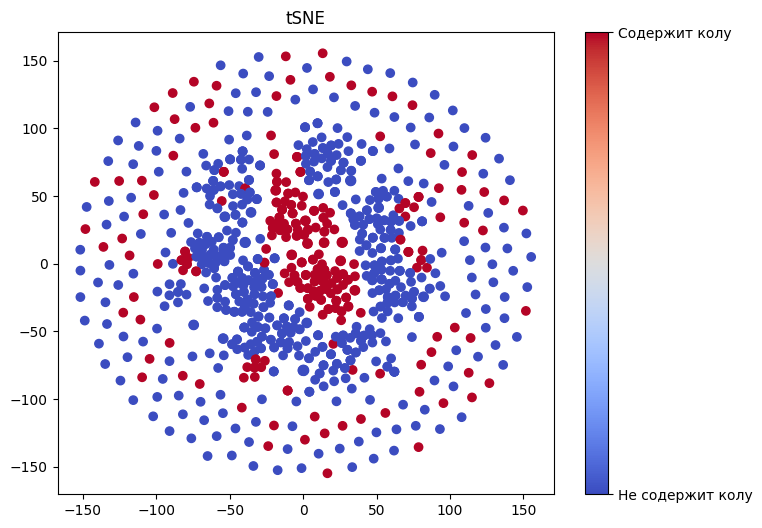

In [17]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(*embedded.T, c = contains_coke, cmap = "coolwarm")
plt.title('tSNE')
cbar = plt.colorbar(scatter, ticks=[0, 1])
cbar.ax.set_yticklabels(['Не содержит колу', 'Содержит колу'])

В моем случае нелинейная проекция методом tSNE лучше, чем NMF, т.к дает больше информации о разделении классов. В данном случае они концентрируются в центре и четко разделены, в отличие от NMF, где все смешалось. Также tSNE выделил несколько кластеров внутри одного класса, что дает лучшее представление о внутренних взаимоотношениях между точками данных. tSNE подходит лучше для визуализации высокоразмерных данных.

#### 10. Из исходной матрицы (из пункта 7) отберем 4 независимые переменные с использованием VarClus
<a id='varclus_use'></a>

In [18]:
clusters = VarClusHi(purchase_matrix, maxeigval2=1, maxclus=4)
clusters.varclus()

In [19]:
rsquare_df = clusters.rsquare
rsquare_df

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
0,0,artichok,0.331882,0.073440,0.721073
1,0,avocado,0.542912,0.020420,0.466617
2,0,baguette,0.325976,0.034173,0.697872
3,0,olives,0.521717,0.110853,0.537912
4,0,turkey,0.269857,0.076899,0.790967
5,0,bourbon,0.277107,0.036053,0.749930
6,1,coke,0.584512,0.077684,0.450483
7,1,ice_crea,0.577705,0.074251,0.456165
8,1,soda,0.339469,0.095253,0.730073
9,1,cracker,0.475879,0.087506,0.574383


- RS_Own - доля объясненной дисперсии внутри кластера
- RS_NC - доля объясненной дисперсии ближайшего кластера

In [20]:
#Переменные с макс R-квадрат в каждом кластере
selected_vars = rsquare_df.groupby('Cluster')['RS_Ratio'].idxmax()
selected_vars_names = rsquare_df.loc[selected_vars]['Variable']

print("Selected variables:", selected_vars_names.tolist())

Selected variables: ['turkey', 'soda', 'bordeaux', 'ham']
